# Import libraries

## TO DO
* 2-layer ResNet to test PONNI
* ke spectra using fftn

In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as mticker

# # import os
# # os.system("pip install pyfftw")
# import pyfftw

In [2]:
# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter_x(val, pos=None):
    return f"$10^{{{val:0.2}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

def rm(x,N):
    return np.convolve(x, np.ones(N), 'valid') / N

def ke_spectra(u, v, w, nbins):
    spd = np.abs( np.fft.rfft2(u[:,0,:]) )**2
    spd = 0
    for j in range(u.shape[1]) :
        ke = (u[:,j,:]*u[:,j,:] + v[:,j,:]*v[:,j,:] + w[:,j,:]*w[:,j,:]) / 2
        spd = spd + np.abs( np.fft.rfft2(ke) )**2
    freq = np.fft.rfftfreq(len(ke[0,:]))
    
    # pd = np.abs( pyfftw.interfaces.numpy_fft.rfft2(u[:,0,:]) )**2
    # spd = 0
    # for j in range(u.shape[1]) :
    #     ke = (u[:,j,:]*u[:,j,:] + v[:,j,:]*v[:,j,:] + w[:,j,:]*w[:,j,:]) / 2
    #     spd = spd + np.abs( pyfftw.interfaces.numpy_fft.rfft2(ke) )**2
    # freq = pyfftw.interfaces.numpy_fft.rfftfreq(len(ke[0,:]))
    
    freq2d = np.sqrt(np.outer(freq,freq))
    spd /= u.shape[1]
    spd = spd.reshape(spd.shape[0]*spd.shape[1])
    freq2d = freq2d.reshape(freq2d.shape[0]*freq2d.shape[1])
    indices = np.argsort(freq2d)
    freq2d = freq2d[indices[:]]
    spd    = spd   [indices[:]]
    
    # L = [[freq2d[i],spd[i]] for i in range(len(freq2d))]
    # L1 = pd.DataFrame(L).groupby(0, as_index=False)[1].mean().values.tolist()
    # freq2d = np.asarray([L1[i][0] for i in range(len(L1))])
    # spd    = np.asarray([L1[i][1] for i in range(len(L1))])
    
    # return freq2d , spd
    
    freq_edges = np.linspace(freq2d[0], freq2d[-1], nbins)
    spd_edges = np.zeros(nbins)
    ID = np.where(freq2d<=freq_edges[0])[0]
    spd_edges[0] = np.sum(spd[ID]) / len(ID)
    for i in range(1,nbins):
        ID = np.where( (freq2d[:]<=freq_edges[i]) & (freq2d[:]>freq_edges[i-1]) )[0]
        spd_edges[i] = np.sum(spd[ID]) / len(ID)

    return freq_edges, spd_edges

# Plot

In [3]:
saveFig = True
t = 10*4
HDdir = '/gpfs/alpine/proj-shared/stf006/muraligm/ML/data/'
avg_size = 21
nbins = 40

nc = Dataset(f"{HDdir}orig.nc", "r")
u = nc.variables["uvel"][t,:,:,:]
v = nc.variables["vvel"][t,:,:,:]
w = nc.variables["wvel"][t,:,:,:]
freq_lo,spd_lo = ke_spectra(u, v, w, nbins)
# spd = rm(spd,avg_size)
# freq = freq[int((avg_size-1)/2):int((avg_size-1)/2+len(spd))]

nc = Dataset(f"{HDdir}sgs.nc", "r")
u = nc.variables["uvel"][t,:,:,:]
v = nc.variables["vvel"][t,:,:,:]
w = nc.variables["wvel"][t,:,:,:]
freq_nn,spd_nn = ke_spectra(u, v, w, nbins)

# nc = Dataset(f"{HDdir}test_hi.nc", "r")
# u = nc.variables["uvel"][t,:,:,:]
# v = nc.variables["vvel"][t,:,:,:]
# w = nc.variables["wvel"][t,:,:,:]
# freq_hi,spd_hi = ke_spectra(u, v, w, nbins)

/tmp/ipykernel_1117/2861317285.py:6: RuntimeWarning: divide by zero encountered in power
  plt.loglog( freq_lo, 1.5e-1 * freq_lo**(-5./3.), '--k', label=r'$k^{-5/3}$')


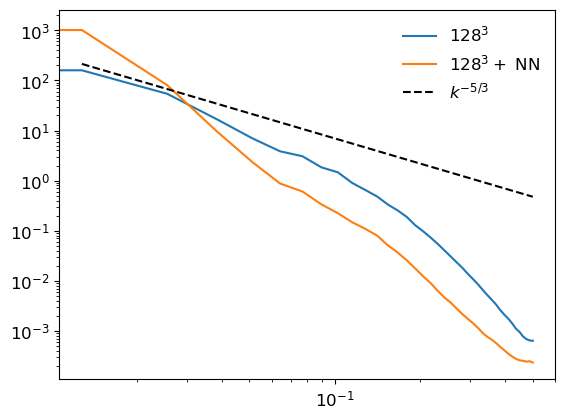

In [9]:
plt.rcParams.update({'font.size': 12})

plt.loglog( freq_lo, spd_lo, label=r'$128^3$')
plt.loglog( freq_nn, spd_nn, label=r'$128^3 +$ NN')
# plt.loglog( freq_hi, spd_hi, label=r'$512^3$')
plt.loglog( freq_lo, 1.5e-1 * freq_lo**(-5./3.), '--k', label=r'$k^{-5/3}$')

plt.legend(frameon=False);
if saveFig: plt.savefig(f'Figs/spectra_time{int(t/4)}.png', bbox_inches='tight');

In [5]:
def spectra_time(nc, tlist, nbins):
    freq_list = np.zeros( (len(tlist), nbins) )
    spd_list = np.zeros( (len(tlist), nbins) )
    for i in range(len(tlist)):
        t = tlist[i]
        u = nc.variables["uvel"][t,:,:,:]
        v = nc.variables["vvel"][t,:,:,:]
        w = nc.variables["wvel"][t,:,:,:]
        freq_list[i,:],spd_list[i,:] = ke_spectra(u, v, w, nbins)
    return freq_list, spd_list

In [6]:
tlist = np.arange(1,11,3)*4
freq_list_lo, spd_list_lo = spectra_time(Dataset(f"{HDdir}orig.nc", "r"), tlist, nbins)
freq_list_nn, spd_list_nn = spectra_time(Dataset(f"{HDdir}sgs.nc", "r"), tlist, nbins)
# freq_list_hi, spd_list_hi = spectra_time(Dataset(f"{HDdir}test_hi.nc", "r"), tlist, nbins)


/tmp/ipykernel_1117/3357937220.py:3: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(freq_list_lo[i,:]), np.ones(nbins)*tlist[i]/4, np.log10(spd_list_lo[i,:]), 'b')
/tmp/ipykernel_1117/3357937220.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(freq_list_nn[i,:]), np.ones(nbins)*tlist[i]/4, np.log10(spd_list_nn[i,:]), 'r')


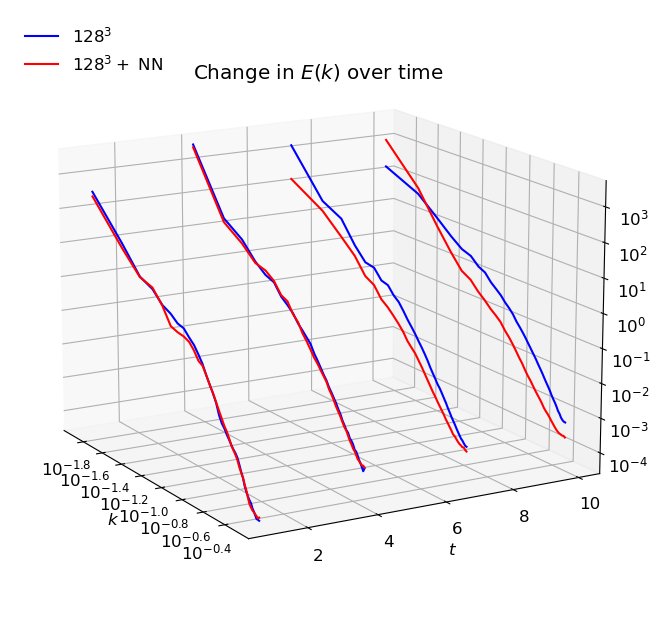

In [10]:
ax = plt.figure(figsize=(10, 8)).add_subplot(projection='3d',facecolor="1")
for i in range(len(tlist)):
    ax.plot(np.log10(freq_list_lo[i,:]), np.ones(nbins)*tlist[i]/4, np.log10(spd_list_lo[i,:]), 'b')
    ax.plot(np.log10(freq_list_nn[i,:]), np.ones(nbins)*tlist[i]/4, np.log10(spd_list_nn[i,:]), 'r')

ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter_x))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.view_init(15, -30)

ax.legend([r'$128^3$', r'$128^3 + $ NN'], frameon=False, loc='upper left')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$t$')
ax.set_title(r'Change in $E(k)$ over time', y=1.0, pad=-14);
if saveFig: plt.savefig(f'Figs/spectra_timevarying.png', bbox_inches='tight');

/tmp/ipykernel_1117/136841570.py:3: RuntimeWarning: divide by zero encountered in log10
  X, Y = np.meshgrid(np.log10(freq_list_lo[0,:]), tlist)
/tmp/ipykernel_1117/136841570.py:8: RuntimeWarning: divide by zero encountered in log10
  X, Y = np.meshgrid(np.log10(freq_list_nn[0,:]), tlist)


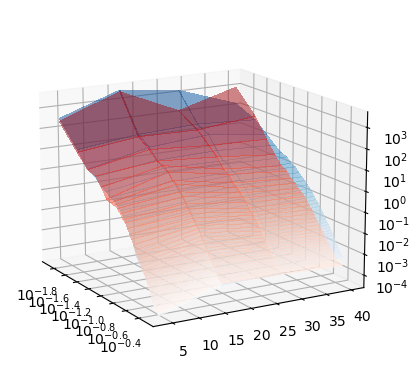

In [8]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
X, Y = np.meshgrid(np.log10(freq_list_lo[0,:]), tlist)
Z = np.log10(spd_list_lo)
surf = ax.plot_surface(X, Y, Z, cmap=cm.Blues,
                       linewidth=0, antialiased=False, alpha=0.5)

X, Y = np.meshgrid(np.log10(freq_list_nn[0,:]), tlist)
Z = np.log10(spd_list_nn)
surf = ax.plot_surface(X, Y, Z, cmap=cm.Reds,
                       linewidth=0, antialiased=False, alpha=0.5)

# ax.set_xscale('log')
# ax.set_zscale('log')
# # Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# # A StrMethodFormatter is used automatically
# ax.zaxis.set_major_formatter('{x:.02f}')

# # # Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)
ax.xaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter_x))
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.view_init(15, -30)

plt.show()